# Build wavelet

Edited by Louise, 28-02-2023

Show how to load wavelets from s2wav.

In [111]:
from jax import jit, config

import s2fft
config.update("jax_enable_x64", True)

import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

import s2wav
from s2wav.filter_factory.filters import filters_directional_vectorised
from s2wav.filter_factory.filters import filters_axisym_vectorised

import scatcovjax.plotting as plot
import scatcovjax.Sphere_lib as sphlib
plot.notebook_plot_format()

# Make axisym wavelets

In [186]:
sampling = "mw"
multiresolution = True
reality = True

L = 128
J_min = 0

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(J_max, J)

7 8


(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='$\\ell$', ylabel='Filters $\\Psi^j_{\\ell 0}$'>)

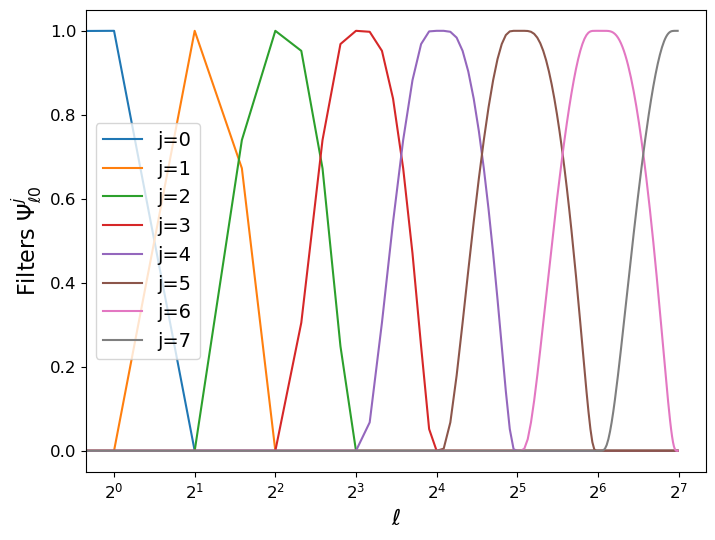

In [187]:
filters = filters_axisym_vectorised(L, J_min)
wlm, slm = filters

# Plot the filters
plot.plot_filters(filters, real=True, m=None)


In [188]:
wlm.shape

(8, 128)

[1.0, 1.4525526146480479, 2.9688932970561877, 5.922870348188997, 11.84408354844712, 23.688407497866464, 47.376807275017946, 32.74638541877524]


Text(0.5, 0, 'j')

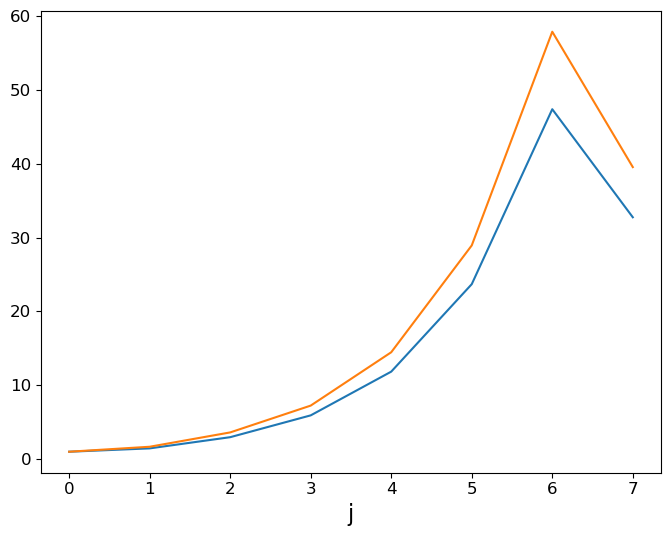

In [189]:
norme_L2, norme_L1 = [], []
for j in range(J):
    norme_L2.append(np.sum(np.abs(wlm[j, :])**2))
    norme_L1.append(np.sum(np.abs(wlm[j, :])))
print(norme_L2)

plt.figure(figsize=(8, 6))
plt.plot(norme_L2, label='Norme L2')
plt.plot(norme_L1, label='Norme L1')
plt.xlabel('j')

# Make directional wavelets

Note that you can make axisym wavelet with the directional function, only set N=1.
But normalisations are different so then if you use the convolution, you need to use the directional convolution.

On génère les ondelettes dans l'espace des HS: $\Psi^j_{\ell n}$. Chaque $n$ sera associé à une orientation.

Le nombre d'orientations est 2N-1. Si N est impair/pair, c'est la partie réelle/imaginaire de $\Psi^j_{\ell n}$ qui est non nulle.

In [190]:
sampling = "mw"
multiresolution = True
reality = True

N = 1
L = 256
J_min = 0

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(J_max, J)

8 9


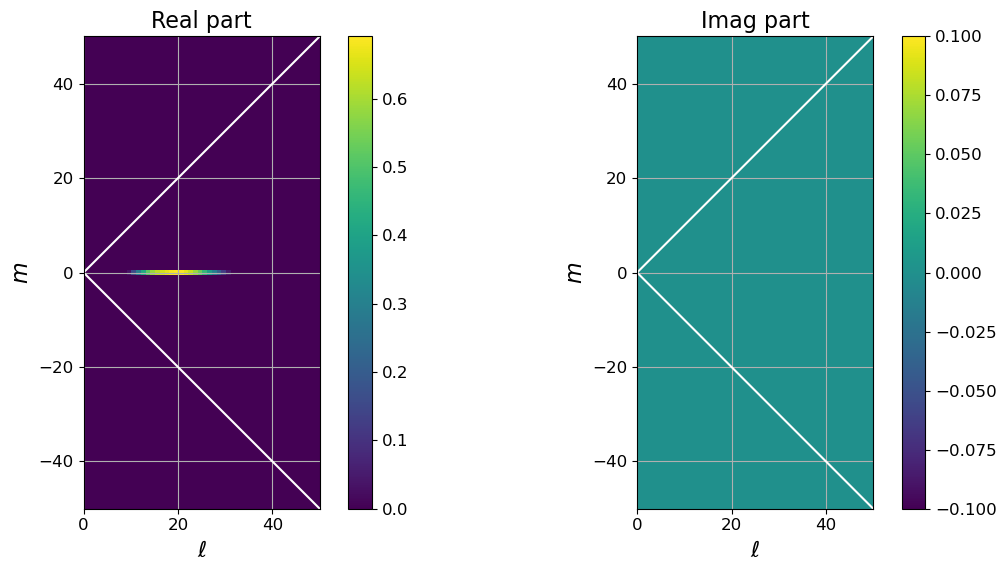

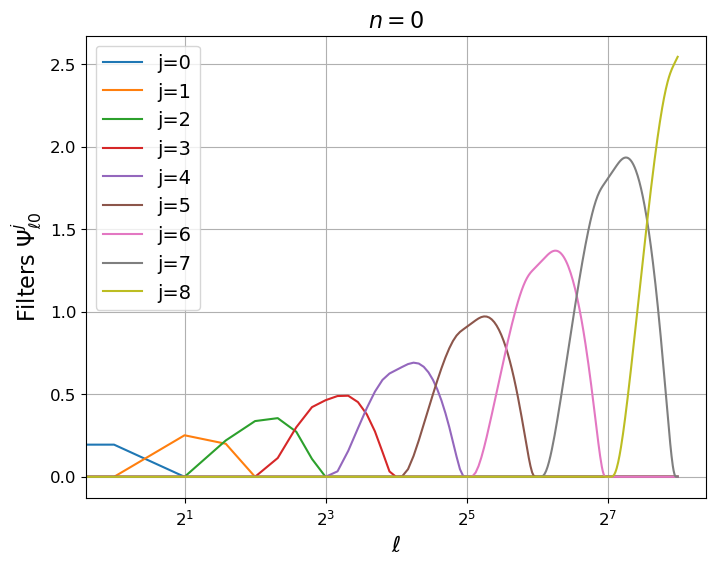

In [191]:
reload(plot)
# Generate the filters
filters = filters_directional_vectorised(L, N, J_min)

# Split the wavelet set and the scaling function
wlm, slm = filters

# Plot the (l,m) plane
j = 4
fig = plot.plot_alm(wlm[j, :, :], lmin=0, lmax=50, mmin=-50, mmax=50)

# Plot the wavelets for a given n
plot.plot_filters(filters, real=True, m=L-1)
plt.title(r'$n=0$')
plt.grid()


### Norme L1 L2

On trace d'abord les normes L1 et L2 des ondelettes:

$ L1_j = \sum\limits_{\ell n} | \Psi^j_{\ell n}|$ et $ L2_j = \sum\limits_{\ell n} | \Psi^j_{\ell n}|^2$

Ces normes ne sont pas constantes.

In [218]:
norme_L2, norme_L1 = [], []
for j in range(J):
    norme_L2.append(np.sum(np.abs(wlm[j, :, :])**2))
    norme_L1.append(np.sum(np.abs(wlm[j, :, :])))
print(norme_L2)

[0.03799544386587666, 0.10344726053096423, 0.37515651890386714, 1.4250689087678299, 5.550314433552838, 21.90124375644943, 87.00494071919097, 346.81969432385415, 366.79260988495986]


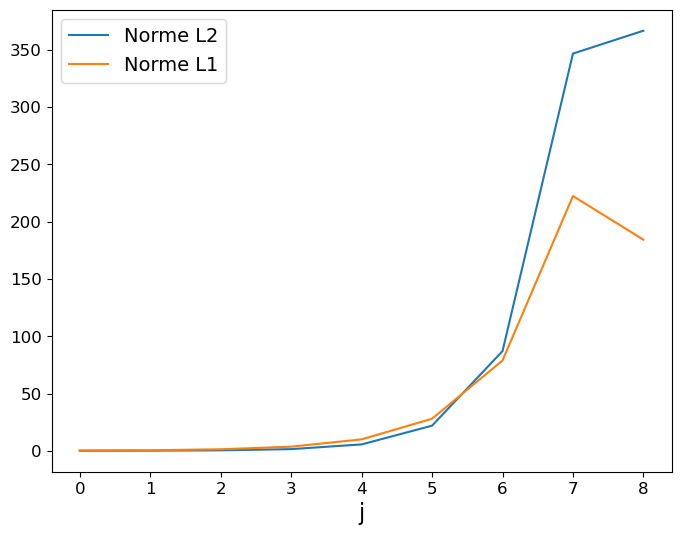

In [219]:
plt.figure(figsize=(8, 6))
plt.plot(norme_L2, label='Norme L2')
plt.plot(norme_L1, label='Norme L1')
plt.xlabel('j')
plt.legend()

 On multiplie $\Psi^j_{\ell n}$ par $\frac{8\pi^2}{2\ell + 1}$ et on recalcule les normes L1 et L2. C'est ce facteur qui est utilisé dans la convolution directionnelle et qui permet d'avoir une norme L2 constante.

$ L1_j = \sum\limits_{\ell n} \left| \frac{8\pi^2}{2\ell + 1} \Psi^j_{\ell n}\right|$ et $ L2_j = \sum\limits_{\ell n} \left| \frac{8\pi^2}{2\ell + 1} \Psi^j_{\ell n}\right|^2$

[26.318945069571612, 20.89595593003425, 24.532490339246444, 25.7885896909886, 26.54565459862895, 26.948882042791062, 27.15493781076467, 27.259222176091335, 12.029611853847323]


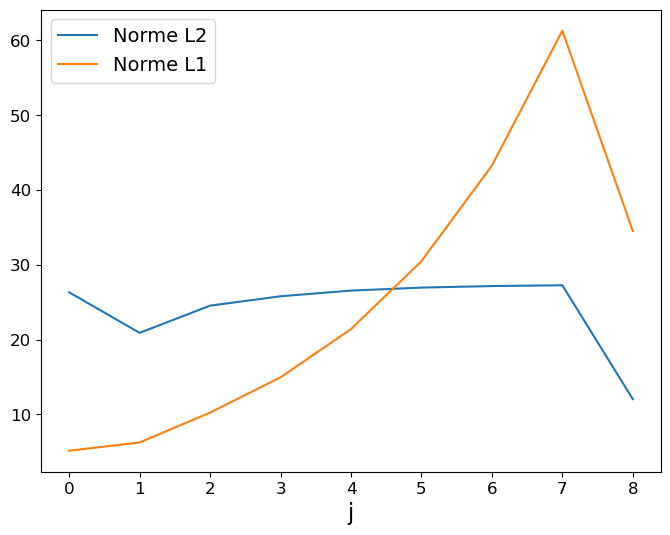

In [194]:
norme_L2, norme_L1 = [], []
for j in range(J):
    wlm_norm = np.einsum(
    "jln, l->jln",
    np.conj(wlm),
    8 * np.pi**2 / (2 * np.arange(L) + 1),
    optimize=True,
    )
    norme_L2.append(np.sum(np.abs(wlm_norm[j, :, :])**2))
    norme_L1.append(np.sum(np.abs(wlm_norm[j, :, :])))
print(norme_L2)

plt.figure(figsize=(8, 6))
plt.plot(norme_L2, label='Norme L2')
plt.plot(norme_L1, label='Norme L1')
plt.xlabel('j')
plt.legend()

### Plot dans l'espace des cartes

On fait une SHT inverse de $\Psi^j_{\ell n}$.

Quand on fait cette opération, on multiplie les $\Psi^j_{\ell n}$ par $\sqrt{\frac{2\ell +1}{4\pi}}$.

In [197]:
w = np.zeros((J, L, 2*L-1))
# Make a map: inverse SHT
for j in range(J):
    w[j, :, :] = s2fft.inverse_jax(wlm[j, :, :], L=L)
print(w.shape)

# Plot the wavelet on the sphere
# j=4
#plot.plot_sphere(w[j, :, :], L, sampling, isnotebook=True)

(9, 256, 511)


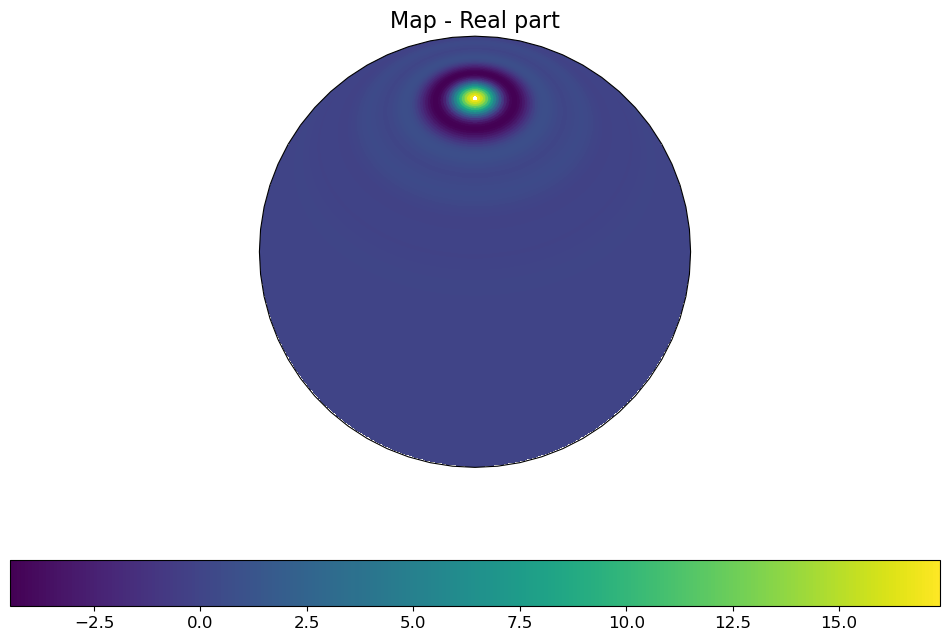

In [198]:
j=4
plot.plot_map_MW_Orthographic(w[j, :, :], central_latitude=45)

[594.4580149867179, 1905.925169956871, 13535.404446485227, 100088.6050577624, 770694.2821250977, 6055362.891633133, 48013405.43533397, 382404194.1666587, 315073443.51600176]


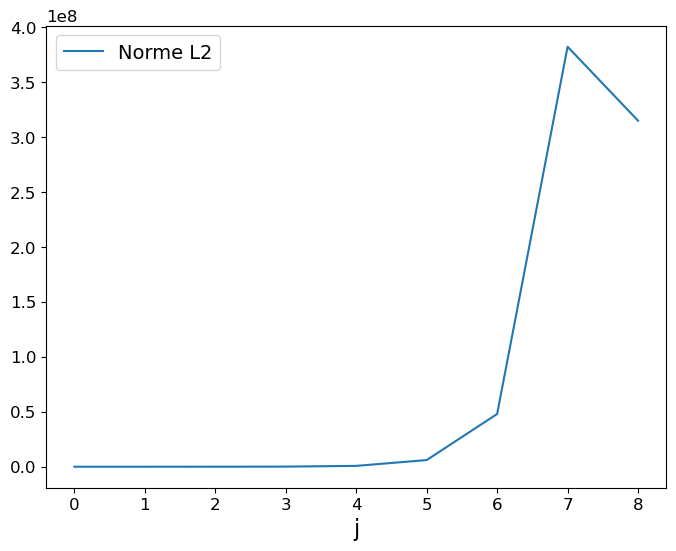

In [201]:
norme_L2_w, norme_L1_w = [], []
for j in range(J):
    norme_L2_w.append(np.sum(np.abs(w[j, :, :])**2))
    norme_L1_w.append(np.sum(np.abs(w[j, :, :])))
print(norme_L2_w)

plt.figure(figsize=(8, 6))
plt.plot(norme_L2_w, label='Norme L2')
# plt.plot(norme_L1_w, label='Norme L1')
plt.xlabel('j')
plt.legend()

# Convolution

### Convolution d'un Dirac

On crée une carte Dirac et on fait une SHT forward pour avoir les flm. Dans cette opération, les $flm$ sont multipliés par $\sqrt{\frac{2\ell +1}{4\pi}}$.


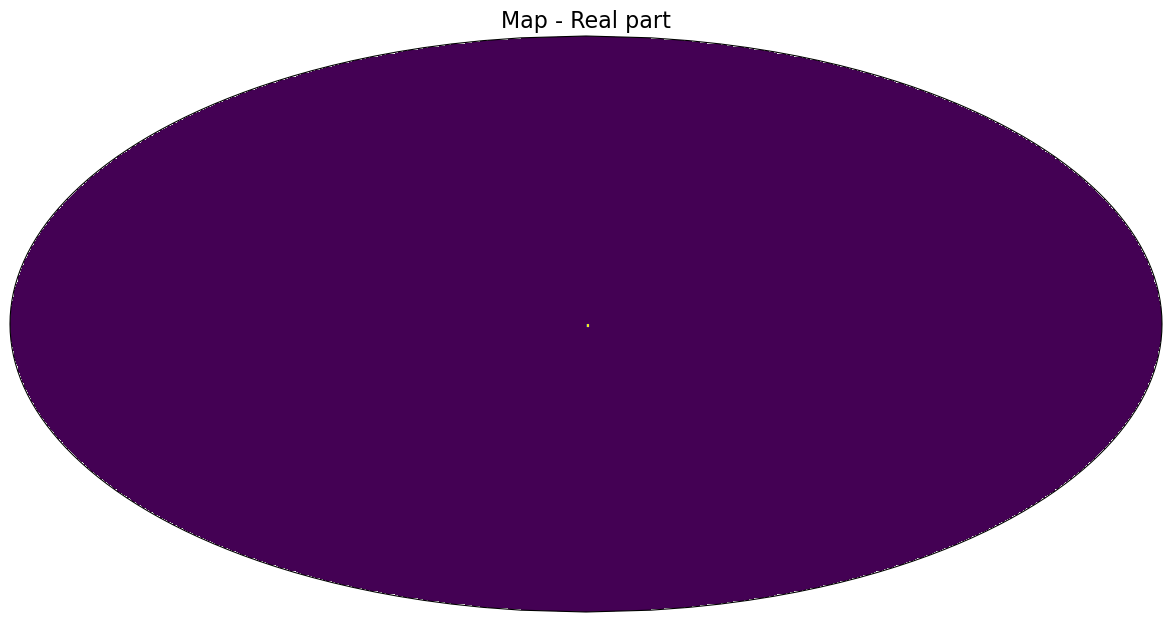

In [202]:
### Make the map
f_dirac = np.zeros((L, 2*L-1))
f_dirac[L//2, L] = 1

plot.plot_map_MW_Mollweide(f_dirac, central_longitude=0)



In [203]:
# Make the SHT
flm_dirac = s2fft.forward_jax(f_dirac, L=L)

Dans `flm_to_analysis()`, on multiplie les filtres par $\frac{8\pi^2}{2\ell +1}$ puis à la fin on fait une WT inverse pour avoir une carte et il y a un facteur $\sqrt{\frac{2\ell +1}{16\pi^3}}$.

In [204]:
### Wavelet transform
W_dirac = s2wav.flm_to_analysis(
    flm_dirac,
    L,
    N,
    J_min,
    sampling=sampling,
    nside=None,
    reality=False,
    multiresolution=multiresolution,
    filters=wlm,
    precomps=None
)

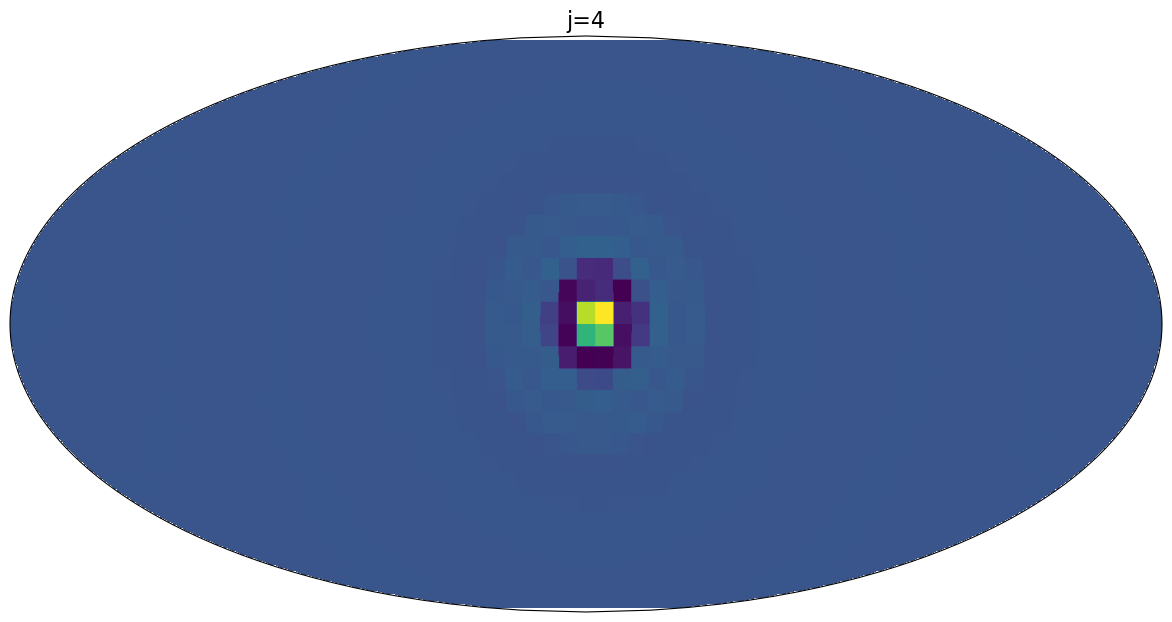

In [206]:
j = 4
plot.plot_map_MW_Mollweide(W_dirac[j][0, :, :], central_longitude=0, title=f'{j=}')

In [209]:
import scatcovjax.Scattering_lib as scatlib
weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution)

In [212]:
len(weights)

9

[Array(8.68421304e-10, dtype=float64), Array(2.39193474e-09, dtype=float64), Array(8.5955045e-09, dtype=float64), Array(3.25952874e-08, dtype=float64), Array(1.26875581e-07, dtype=float64), Array(5.00580541e-07, dtype=float64), Array(1.98856599e-06, dtype=float64), Array(7.92685341e-06, dtype=float64), Array(8.37965664e-06, dtype=float64)]


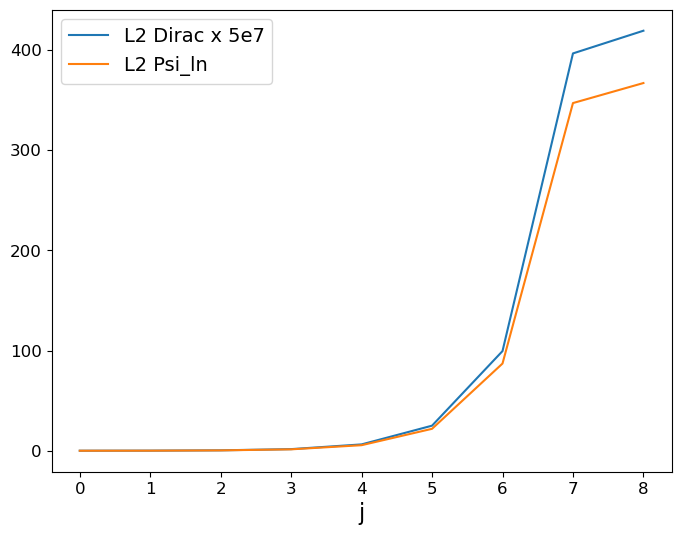

In [229]:
norme_L2_dirac, norme_L1_dirac = [], []
for j in range(J):
    norme_L2_dirac.append(np.sum(np.abs(W_dirac[j][0, :, :])**2 * weights[j][:, None]))
    norme_L1_dirac.append(np.sum(np.abs(W_dirac[j][0, :, :])* weights[j][:, None]))
print(norme_L2_dirac)

plt.figure(figsize=(8, 6))
plt.plot(np.array(norme_L2_dirac)*5e7, label='L2 Dirac x 5e7')
plt.plot(np.array(norme_L2), label='L2 Psi_ln')
# plt.plot(norme_L1_dirac, label='Norme L1')
plt.xlabel('j')
plt.legend()

In [173]:
W_dirac[0].shape

(1, 4, 7)

[1.4404812167520103e-06, 7.910343769270161e-06, 9.952227152914294e-06, 2.588222942574693e-05, 8.108389079914102e-05, 0.0003144625902276076, 0.001242928289915888, 0.00496961796144916, 0.005809457580626138]


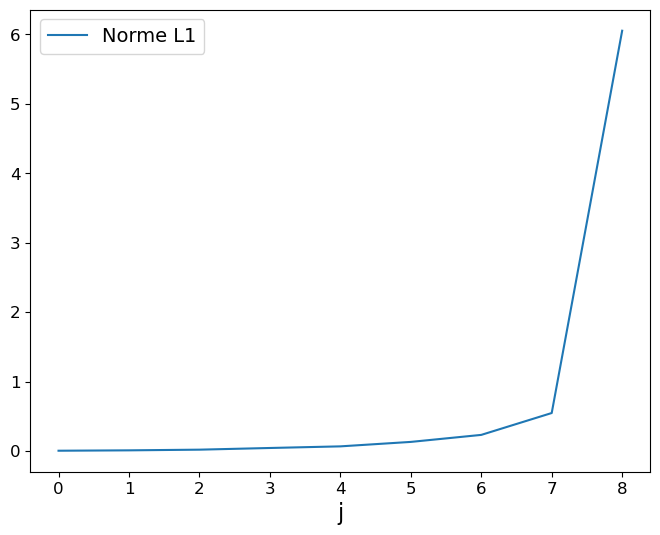

In [178]:
norme_L2, norme_L1 = [], []
for j in range(J):
    Lj = np.shape(W_dirac[j])[1]
    W_dirac_norm = np.einsum(
    "ln, l->ln",
    W_dirac[j][0, :, :],
    8 * np.pi**2 / (2 * np.arange(Lj) + 1),
    optimize=True,
    )
    norme_L2.append(np.sum(np.abs(W_dirac_norm[:, :])**2))
    norme_L1.append(np.sum(np.abs(W_dirac_norm[:, :])))
print(norme_L2)

plt.figure(figsize=(8, 6))
# plt.plot(norme_L2, label='Norme L2')
plt.plot(norme_L1, label='Norme L1')
plt.xlabel('j')
plt.legend()

### Convolution d'une carte

In [23]:
# f_target, flm_target = sphlib.make_pysm_sky(L, 'dust', sampling=sampling, nest=False, normalize=True, reality=reality)

f_target, flm_target = sphlib.make_MW_lensing(L, normalize=True, reality=False)

In [29]:
plot.plot_sphere(f_target, L=L, sampling=sampling)

In [24]:
W = s2wav.flm_to_analysis(
    flm_target,
    L,
    N,
    J_min,
    sampling=sampling,
    nside=None,
    reality=False,
    multiresolution=multiresolution,
    filters=wlm,
    precomps=None
)

In [25]:
W[-1].shape


(3, 256, 511)

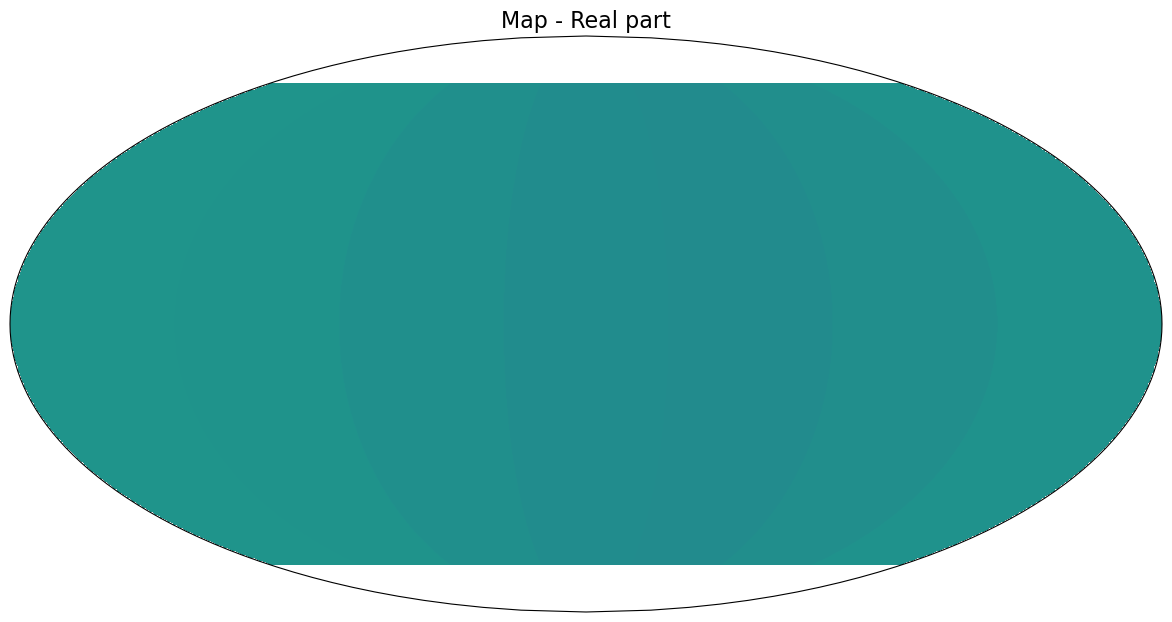

In [60]:
plot.plot_map_MW_Mollweide(W[0][0, :, :], central_longitude=0, vmin=-0.4, vmax=0.4)
# plot.plot_map_MW_Orthographic(W[-3][0, :, :], central_latitude=45, vmin=-0.3, vmax=0.3)

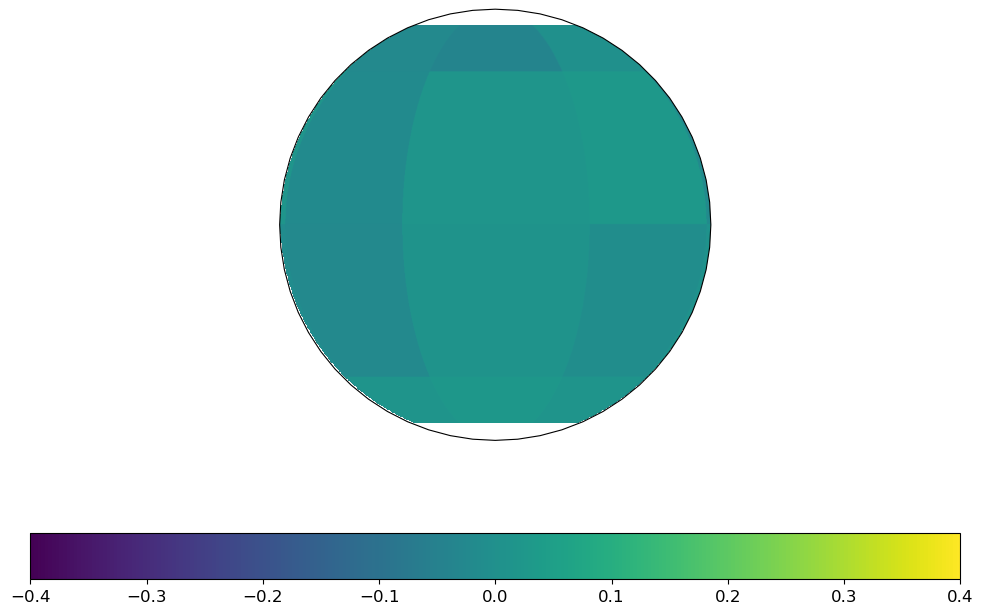

In [61]:
# plot.plot_map_MW_Mollweide(W[-3][1, :, :], central_longitude=0, vmin=-0.4, vmax=0.4)

plot.plot_map_MW_Orthographic(W[1][1, :, :], central_latitude=0, vmin=-0.4, vmax=0.4, title='')

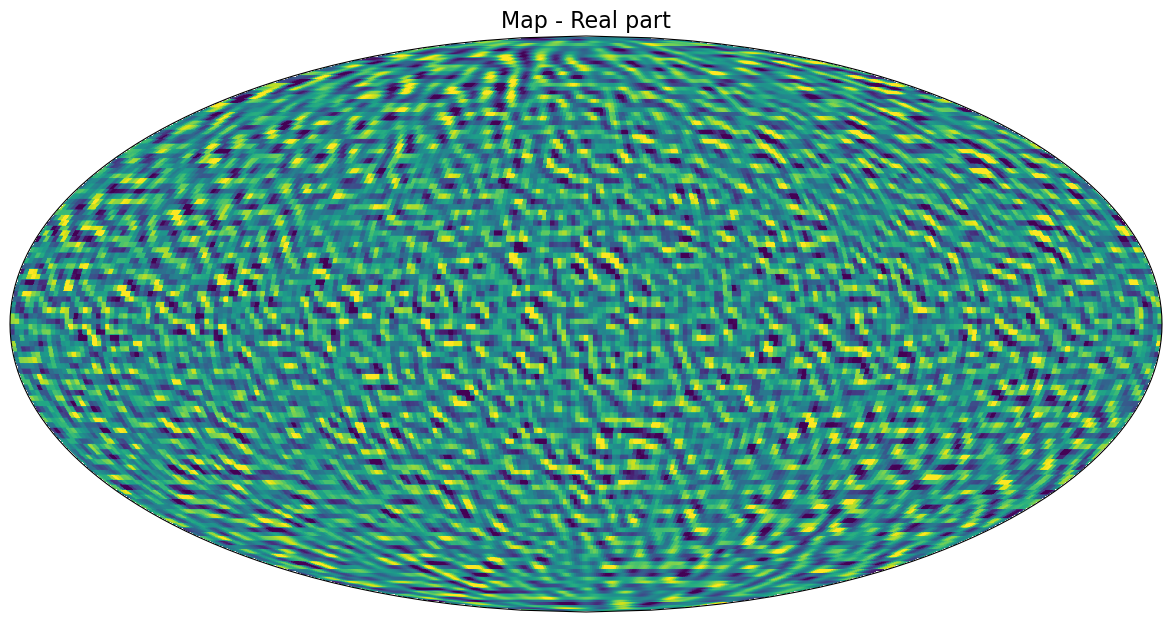

In [48]:
plot.plot_map_MW_Mollweide(W[-3][2, :, :], central_longitude=0, vmin=-0.4, vmax=0.4)

In [65]:
plot.plot_sphere(W[2][2, :, :], 8, sampling, isnotebook=True)

Widget(value="<iframe src='http://localhost:42205/index.html?ui=P_0x7f953d96ff10_0&reconnect=auto' style='widt…

In [66]:
1.5*512

768.0

In [67]:
3*256

768